<a href="https://colab.research.google.com/github/ggwnsghgg/Exchange_rate_prediction_Project/blob/main/%EB%8B%A4%EB%B3%80%EB%9F%89_LSTM_%ED%85%8C%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [2]:
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/Test_data.csv'

Mounted at /content/drive


In [3]:
data = pd.read_csv(filename)
data.head()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
0,2014.01.02,1.055,4.264,2.78,0.0956,80.79,2.51,1.967
1,2014.01.03,1.050,4.209,2.78,0.0950,80.96,2.50,1.946
2,2014.01.06,1.054,4.221,2.77,0.0945,80.81,2.48,1.953
3,2014.01.07,1.062,4.233,2.75,0.0926,80.98,2.50,1.959
4,2014.01.08,1.067,4.232,2.75,0.0925,81.16,2.49,1.959


In [4]:
data.interpolate(inplace=True)
data.isnull().sum()

Date            0
ExchangeRate    0
KRX100          0
KORIBOR         0
LIBOR           0
달러지수 (종가)       0
콜금리             0
KOSPI           0
dtype: int64

In [13]:
data["KRX100"] = pd.to_numeric(data.KRX100, errors='coerce')

In [ ]:
# data['ExchangeRate'] = data['ExchangeRate'].str.replace(',','')
# data['KRX100'] = data['KRX100'].str.replace(',','')
# data['KOSPI'] = data['KOSPI'].str.replace(',','')

AttributeError: ignored

In [14]:
data

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
0,2014.01.02,1.055,4.264,2.78,0.0956,80.79,2.51,1.967
1,2014.01.03,1.050,4.209,2.78,0.0950,80.96,2.50,1.946
2,2014.01.06,1.054,4.221,2.77,0.0945,80.81,2.48,1.953
3,2014.01.07,1.062,4.233,2.75,0.0926,80.98,2.50,1.959
4,2014.01.08,1.067,4.232,2.75,0.0925,81.16,2.49,1.959
...,...,...,...,...,...,...,...,...
1757,2021.02.17,1.099,6.653,0.87,0.0000,90.95,0.47,3.134
1758,2021.02.18,1.107,6.712,0.87,0.0000,90.59,0.49,3.087
1759,2021.02.19,1.105,6.636,0.86,0.0000,90.36,0.51,3.108
1760,2021.02.22,1.107,6.607,0.86,0.0000,90.01,0.50,3.080


In [15]:
test = data[['ExchangeRate','KRX100']].values

In [16]:
data['KRX100']

0       4.264
1       4.209
2       4.221
3       4.233
4       4.232
        ...  
1757    6.653
1758    6.712
1759    6.636
1760    6.607
1761      NaN
Name: KRX100, Length: 1762, dtype: float64

In [17]:
test.shape

(1762, 2)

In [18]:
test

array([[1.055, 4.264],
       [1.05 , 4.209],
       [1.054, 4.221],
       ...,
       [1.105, 6.636],
       [1.107, 6.607],
       [1.106,   nan]])

In [19]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(test) #값을 0~1로 떨어뜨린다

In [23]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [24]:
reframed = series_to_supervised(scaled, 1, 1) #t-1시점,t시점 데이터를 한 행으로 둔다

In [25]:
values = reframed.values
n_train_hours = 365 * 24 #1년치 데이터만 가져온다
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [31]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [32]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
25/25 - 2s - loss: 0.5285
Epoch 2/50
25/25 - 0s - loss: 0.3124
Epoch 3/50
25/25 - 0s - loss: 0.1128
Epoch 4/50
25/25 - 0s - loss: 0.0901
Epoch 5/50
25/25 - 0s - loss: 0.0803
Epoch 6/50
25/25 - 0s - loss: 0.0733
Epoch 7/50
25/25 - 0s - loss: 0.0665
Epoch 8/50
25/25 - 0s - loss: 0.0605
Epoch 9/50
25/25 - 0s - loss: 0.0550
Epoch 10/50
25/25 - 0s - loss: 0.0501
Epoch 11/50
25/25 - 0s - loss: 0.0463
Epoch 12/50
25/25 - 0s - loss: 0.0439
Epoch 13/50
25/25 - 0s - loss: 0.0445
Epoch 14/50
25/25 - 0s - loss: 0.0450
Epoch 15/50
25/25 - 0s - loss: 0.0436
Epoch 16/50
25/25 - 0s - loss: 0.0441
Epoch 17/50
25/25 - 0s - loss: 0.0425
Epoch 18/50
25/25 - 0s - loss: 0.0431
Epoch 19/50
25/25 - 0s - loss: 0.0415
Epoch 20/50
25/25 - 0s - loss: 0.0422
Epoch 21/50
25/25 - 0s - loss: 0.0404
Epoch 22/50
25/25 - 0s - loss: 0.0415
Epoch 23/50
25/25 - 0s - loss: 0.0393
Epoch 24/50
25/25 - 0s - loss: 0.0408
Epoch 25/50
25/25 - 0s - loss: 0.0383
Epoch 26/50
25/25 - 0s - loss: 0.0399
Epoch 27/50
25/25 - 0

KeyError: ignored

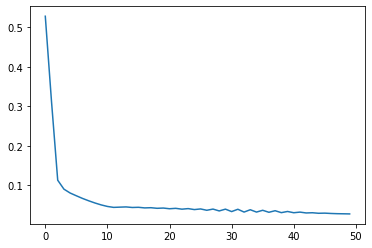

In [34]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

ValueError: ignored

In [ ]:
# lookback = 50
# X = []
# y = []

# for i in range(len(test)-lookback):
#     X.append(test[i:i+lookback])
#     y.append(test[i+lookback,[1]])

In [ ]:
# # X = np.array(X)
# X = np.asarray(X).astype(np.float32)
# # y = np.array(y)
# y = np.asarray(y).astype(np.float32)

In [ ]:
# X[0]

array([[1.055, 4.264],
       [1.05 , 4.209],
       [1.054, 4.221],
       [1.062, 4.233],
       [1.067, 4.232],
       [1.066, 4.199],
       [1.064, 4.175],
       [1.062, 4.197],
       [1.056, 4.189],
       [1.058, 4.207],
       [1.062, 4.216],
       [1.064, 4.183],
       [1.061, 4.2  ],
       [1.063, 4.225],
       [1.064, 4.238],
       [1.068, 4.189],
       [1.071, 4.168],
       [1.077, 4.098],
       [1.084, 4.121],
       [1.079, 4.175],
       [1.071, 4.121],
       [1.082, 4.044],
       [1.086, 4.063],
       [1.079, 4.102],
       [1.076, 4.128],
       [1.075, 4.125],
       [1.071, 4.134],
       [1.072, 4.143],
       [1.064, 4.124],
       [1.063, 4.153],
       [1.061, 4.175],
       [1.06 , 4.174],
       [1.064, 4.164],
       [1.067, 4.125],
       [1.071, 4.189],
       [1.073, 4.168],
       [1.076, 4.206],
       [1.07 , 4.223],
       [1.069, 4.243],
       [1.067, 4.241],
       [1.066, 4.213],
       [1.071, 4.185],
       [1.072, 4.223],
       [1.0

In [ ]:
# X.shape, y.shape

((1712, 50, 2), (1712, 1))

In [ ]:
# X_train = X[:-50-lookback]
# X_test = X[-300:] 
# y_train = y[:-50-lookback]
# y_test = y[-300:]

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1612, 50, 2), (300, 50, 2), (1612, 1), (300, 1))

In [ ]:
# model = Sequential()

# model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

# model.add(LSTM(32, return_sequences=False))

# model.add(Dense(1, activation='linear'))

# model.compile(loss='mse', optimizer='adam')

# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# h = model.fit(X_train, y_train,
#     batch_size=32,validation_data=(X_test, y_test), epochs=50)

Epoch 1/50


ValueError: ignored